# Outliers, Anomalias e “Dados Mentindo” ⚠️ (Aula prática — até 1h)

> **Objetivo:** você vai ver como **poucos pontos “estranhos”** conseguem distorcer métricas, gráficos e decisões — e como lidar com isso **sem autoengano**.

### O que você vai aprender (na prática)
- Tipos de outliers:
  - **Erro / anomalia** (ex.: valor digitado com zero a mais, reembolso negativo, moeda errada)
  - **Comportamento real** (ex.: “heavy users”/clientes VIP)
- Quando **remover**, quando **corrigir** e quando **segmentar**
- Impacto em KPIs (ex.: **ticket médio/AOV**, ranking de canais, decisões de budget)
- Comparar o “mesmo dataset”:
  - média **com vs sem** outliers
  - boxplot **antes/depois**
  - simular uma decisão errada por não tratar outliers

---

## Roteiro sugerido (para você conduzir em 1h)
- 0–5 min: contexto e por que isso importa
- 5–15 min: criar dataset + identificar sintomas
- 15–30 min: detectar outliers (IQR, z-score, MAD) + visualizar
- 30–45 min: estratégias (remover/corrigir/segmentar) + comparar KPIs
- 45–60 min: **simulação de decisão** (budget por canal) + discussão crítica


In [ ]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
pd.set_option("display.max_columns", 50)


## 1) Criando um dataset “vida real” (com problemas de verdade)

Vamos simular pedidos de e-commerce com:
- `order_value` (valor do pedido)
- `channel` (canal de aquisição)
- `segment` (tipo de cliente)
- `is_refund` (reembolso/cancelamento)

E vamos inserir 3 tipos de “pontos estranhos”:
1) **Erro de digitação**: valores 10x ou 100x maiores (zero a mais)
2) **Reembolso registrado como valor negativo** (isso é *real*, mas precisa ser tratado)
3) **Clientes VIP**: valores altos *legítimos* (não são erro; são um segmento)

> A moral: **outlier não é sinônimo de “dado ruim”**.


In [ ]:
# Gerando dados base (sem anomalias)
n = 5000

channels = ["Paid Search", "Social Ads", "Email", "Organic", "Affiliate"]
segments = ["Regular", "New", "VIP"]

df = pd.DataFrame({
    "order_id": np.arange(1, n+1),
    "customer_id": np.random.randint(1, 1200, size=n),
    "channel": np.random.choice(channels, size=n, p=[0.28, 0.22, 0.12, 0.30, 0.08]),
    "segment": np.random.choice(segments, size=n, p=[0.78, 0.20, 0.02])
})

# Valores típicos por segmento (distribuições diferentes)
# Regular: ticket ~ 120 (desvio 50)
# New: ticket ~ 80 (desvio 35)
# VIP: ticket ~ 700 (desvio 250) -> legítimo
def sample_order_value(seg, size):
    if seg == "Regular":
        return np.random.lognormal(mean=np.log(120), sigma=0.45, size=size)
    if seg == "New":
        return np.random.lognormal(mean=np.log(80), sigma=0.50, size=size)
    # VIP
    return np.random.lognormal(mean=np.log(700), sigma=0.55, size=size)

df["order_value"] = 0.0
for seg in segments:
    idx = df["segment"] == seg
    df.loc[idx, "order_value"] = sample_order_value(seg, idx.sum())

# Reembolsos (alguns pedidos viram refund)
df["is_refund"] = np.random.choice([0, 1], size=n, p=[0.96, 0.04])

# Guardamos o valor original antes de aplicar reembolso/anomalias
df["order_value_raw"] = df["order_value"].copy()

# Aplicar reembolso como valor negativo (isso acontece no mundo real)
df.loc[df["is_refund"] == 1, "order_value"] *= -1

df.head()


,order_id,customer_id,channel,segment,order_value,is_refund,order_value_raw
0,1,1127,Paid Search,Regular,78.841887,0,78.841887
1,2,861,Social Ads,Regular,143.975174,0,143.975174
2,3,1131,Organic,Regular,94.779069,0,94.779069
3,4,1096,Organic,Regular,93.335700,0,93.335700
4,5,1045,Organic,Regular,85.090501,0,85.090501


### Check rápido: estatísticas e “cheiro de problema”

Vamos olhar:
- mínimos/máximos
- média vs mediana
- percentis

Dica: quando a média está “muito distante” da mediana, pode ser um sinal (não é prova) de cauda longa/outliers.


In [ ]:
desc = df["order_value"].describe(percentiles=[0.5, 0.9, 0.95, 0.99])
desc


,order_value
count,5000.000000
mean,126.094758
std,151.478554
min,-1410.102448
50%,110.910541
90%,210.982373
95%,263.547297
99%,681.410795
max,3518.769086


## 2) Inserindo anomalias de digitação (“zero a mais”) e moeda errada

Agora vamos adicionar **erros** deliberados:
- alguns pedidos positivos ficam 10x ou 100x maiores
- alguns pedidos ficam absurdos (moeda errada) — ex.: registrou centavos como reais

> Observação: vamos **marcar** o que inserimos para poder comparar depois (em dados reais você não tem essa etiqueta!).


In [ ]:
df = df.copy()
df["anomaly_type"] = "none"

# Vamos escolher alguns pedidos NÃO refund para virar erro de digitação
eligible = df.query("is_refund == 0").index

n_typo_10x = 18
n_typo_100x = 6
n_currency = 8

typo_10x_idx = np.random.choice(eligible, size=n_typo_10x, replace=False)
remaining = eligible.difference(typo_10x_idx)

typo_100x_idx = np.random.choice(remaining, size=n_typo_100x, replace=False)
remaining = remaining.difference(typo_100x_idx)

currency_idx = np.random.choice(remaining, size=n_currency, replace=False)

# Aplicar
df.loc[typo_10x_idx, "order_value"] *= 10
df.loc[typo_10x_idx, "anomaly_type"] = "typo_10x"

df.loc[typo_100x_idx, "order_value"] *= 100
df.loc[typo_100x_idx, "anomaly_type"] = "typo_100x"

# Moeda errada: multiplica por 1000 (bem absurdo)
df.loc[currency_idx, "order_value"] *= 1000
df.loc[currency_idx, "anomaly_type"] = "currency_error"

df["anomaly_type"].value_counts()


,count
anomaly_type,
none,4968
typo_10x,18
currency_error,8
typo_100x,6


## 3) Visualização: boxplot e distribuição (antes de qualquer regra)

Primeiro, vamos ver o impacto “no olho”.

⚠️ Cuidado: com caudas longas, alguns gráficos podem “achatar” o miolo.


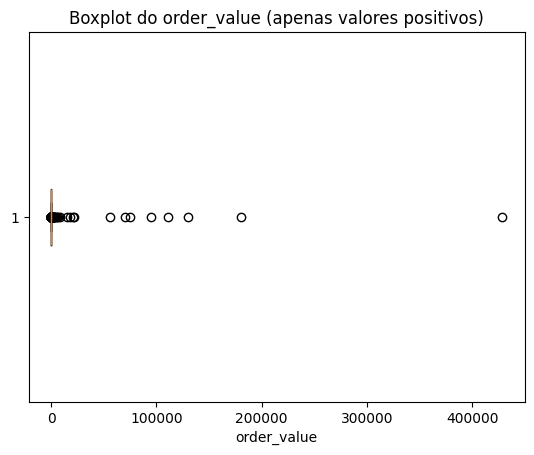

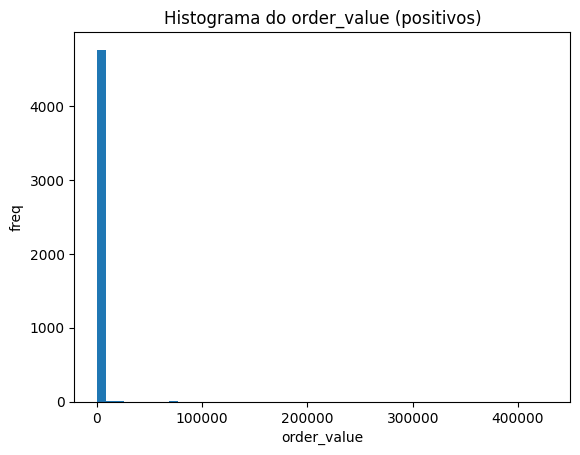

In [ ]:
# Para visualizar distribuição, vamos olhar apenas pedidos não-refund (valores positivos)
pos = df.query("order_value > 0")

plt.figure()
plt.boxplot(pos["order_value"], vert=False)
plt.title("Boxplot do order_value (apenas valores positivos)")
plt.xlabel("order_value")
plt.show()

plt.figure()
plt.hist(pos["order_value"], bins=50)
plt.title("Histograma do order_value (positivos)")
plt.xlabel("order_value")
plt.ylabel("freq")
plt.show()


### Zoom no “miolo” (sem perder o todo)

Uma técnica simples: limitar o eixo pelo percentil 99 para enxergar o grosso — **sem fingir que o resto não existe**.


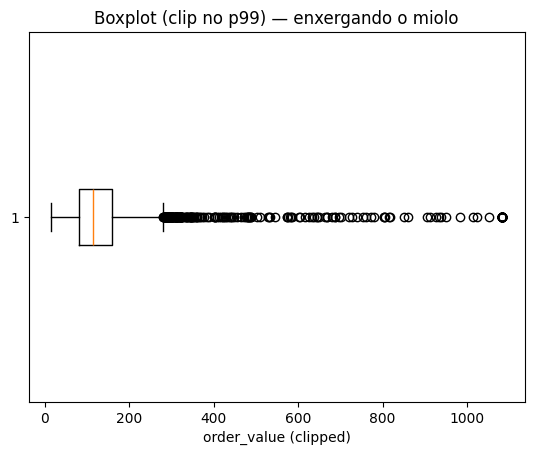

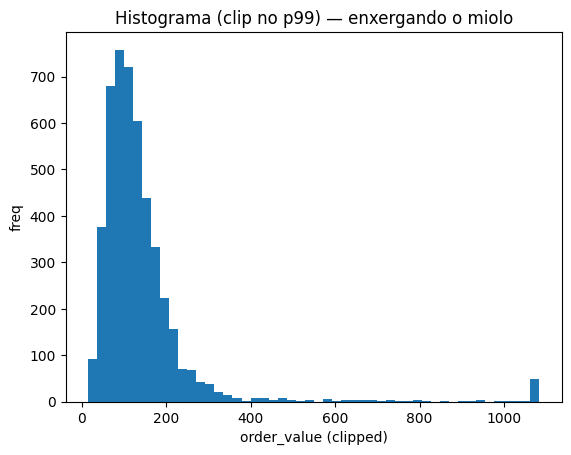

np.float64(1082.9638753521422)

In [ ]:
p99 = pos["order_value"].quantile(0.99)

plt.figure()
plt.boxplot(pos["order_value"].clip(upper=p99), vert=False)
plt.title("Boxplot (clip no p99) — enxergando o miolo")
plt.xlabel("order_value (clipped)")
plt.show()

plt.figure()
plt.hist(pos["order_value"].clip(upper=p99), bins=50)
plt.title("Histograma (clip no p99) — enxergando o miolo")
plt.xlabel("order_value (clipped)")
plt.ylabel("freq")
plt.show()

p99


## 4) Detecção de outliers (3 abordagens)

Vamos aplicar 3 formas comuns e comparar.

### 4.1) IQR (Interquartile Range)
Regra clássica:
- Q1 = 25%
- Q3 = 75%
- IQR = Q3 - Q1
- Outlier alto: > Q3 + 1.5*IQR

### 4.2) Z-score (média e desvio padrão)
Outlier se |z| > 3 (bem comum).
⚠️ Ruim quando a distribuição é bem assimétrica e já tem outliers, porque média/desvio “se contaminam”.

### 4.3) MAD (Median Absolute Deviation)
Mais robusto: usa mediana e desvio absoluto mediano.
Boa opção para cauda longa.

> Vamos usar somente valores positivos (sem refund) para o exemplo de ticket.


In [ ]:
pos = df.query("order_value > 0").copy()

# IQR
q1 = pos["order_value"].quantile(0.25)
q3 = pos["order_value"].quantile(0.75)
iqr = q3 - q1
iqr_upper = q3 + 1.5 * iqr
pos["is_outlier_iqr"] = pos["order_value"] > iqr_upper

# Z-score
mean = pos["order_value"].mean()
std = pos["order_value"].std(ddof=0)
pos["zscore"] = (pos["order_value"] - mean) / (std if std > 0 else 1)
pos["is_outlier_z3"] = pos["zscore"].abs() > 3

# MAD (robusto)
median = pos["order_value"].median()
mad = np.median(np.abs(pos["order_value"] - median))
# Escala aproximada para comparar com zscore em dist normal
pos["modified_z"] = 0.6745 * (pos["order_value"] - median) / (mad if mad > 0 else 1)
pos["is_outlier_mad"] = pos["modified_z"].abs() > 3.5

pd.DataFrame({
    "IQR_outliers": [pos["is_outlier_iqr"].sum()],
    "Z3_outliers": [pos["is_outlier_z3"].sum()],
    "MAD_outliers": [pos["is_outlier_mad"].sum()],
    "Total_pos": [len(pos)]
})


,IQR_outliers,Z3_outliers,MAD_outliers,Total_pos
0,244,8,178,4773


### Onde estão os casos “piorzinhos”?

Vamos ordenar pelos maiores valores e ver:
- se eram VIP legítimos
- se eram nossos erros simulados (`anomaly_type`)

> Em dados reais, você valida com contexto: logs, fonte, moeda, unidade, etc.


In [ ]:
cols = ["order_id", "customer_id", "channel", "segment", "order_value", "anomaly_type",
        "is_outlier_iqr", "is_outlier_z3", "is_outlier_mad"]

pos.sort_values("order_value", ascending=False)[cols].head(20)


,order_id,customer_id,channel,segment,order_value,anomaly_type,is_outlier_iqr,is_outlier_z3,is_outlier_mad
4180,4181,345,Organic,VIP,428327.078020,currency_error,True,True,True
1974,1975,833,Paid Search,Regular,179893.662179,currency_error,True,True,True
2727,2728,520,Email,Regular,130406.711693,currency_error,True,True,True
2725,2726,103,Organic,Regular,110961.782573,currency_error,True,True,True
4804,4805,440,Organic,Regular,94419.805014,currency_error,True,True,True
2514,2515,930,Organic,Regular,74814.703215,currency_error,True,True,True
3169,3170,1103,Social Ads,Regular,70444.853852,currency_error,True,True,True
2155,2156,160,Paid Search,Regular,55750.131588,currency_error,True,True,True
4652,4653,1148,Organic,Regular,22164.836567,typo_100x,True,False,True
2239,2240,209,Social Ads,Regular,20507.824396,typo_100x,True,False,True


## 5) **Outlier ≠ dado ruim**: decidindo o que fazer

Agora vem a parte “adulta” 😄

### Estratégias típicas
1) **Corrigir** (se é erro claro)  
   Ex.: moeda errada, zero a mais, unidade errada

2) **Remover** (se é inválido e não dá pra corrigir)  
   Ex.: valor impossível, duplicata irreparável

3) **Segmentar** (se é comportamento real)  
   Ex.: VIPs, B2B vs B2C, regiões com ticket muito diferente

4) **Capping/Winsorization** (travar em percentil)  
   Útil quando você quer estabilidade, mas não pode perder observações

5) **Usar métricas robustas**  
   Mediana, trimmed mean, percentis, etc.

> Nesta aula, vamos implementar 3 abordagens e comparar impacto nos KPIs:
- **Sem tratar** (baseline)
- **Corrigir erros óbvios** (nossa marcação vai ajudar)
- **Segmentar VIP** + usar **mediana** para ticket “geral”


In [ ]:
def kpi_summary(data, label):
    # Considerando somente pedidos positivos para ticket médio (AOV)
    pos = data.query("order_value > 0")
    return pd.Series({
        "label": label,
        "orders_pos": len(pos),
        "AOV_mean": pos["order_value"].mean(),
        "AOV_median": pos["order_value"].median(),
        "p95": pos["order_value"].quantile(0.95),
        "p99": pos["order_value"].quantile(0.99),
        "max": pos["order_value"].max()
    })

baseline = df.copy()

# 1) Corrigir erros óbvios (como se tivéssemos validado com a fonte)
# - typo_10x: divide por 10
# - typo_100x: divide por 100
# - currency_error: divide por 1000
corrected = df.copy()
corrected.loc[corrected["anomaly_type"] == "typo_10x", "order_value"] /= 10
corrected.loc[corrected["anomaly_type"] == "typo_100x", "order_value"] /= 100
corrected.loc[corrected["anomaly_type"] == "currency_error", "order_value"] /= 1000

# 2) Segmentação VIP (não é correção; é análise separada)
# Aqui a ideia é não “jogar fora” VIP, mas não deixar que distorça o geral.
segmented = corrected.copy()

summary = pd.DataFrame([
    kpi_summary(baseline, "baseline (sem tratar)"),
    kpi_summary(corrected, "corrigido (erros óbvios)"),
    kpi_summary(segmented.query("segment != 'VIP'"), "sem VIP (para geral)"),
    kpi_summary(segmented.query("segment == 'VIP'"), "somente VIP"),
]).reset_index(drop=True)

summary


,label,orders_pos,AOV_mean,AOV_median,p95,p99,max
0,baseline (sem tratar),4773,402.482450,115.194594,282.091585,1082.963875,428327.078020
1,corrigido (erros óbvios),4773,138.753770,114.676093,265.763546,688.857110,3518.769086
2,sem VIP (para geral),4681,124.405726,113.302356,237.749907,322.796898,576.994750
3,somente VIP,92,868.788456,699.156340,1706.713437,2462.574342,3518.769086


## 6) Boxplot antes/depois (mesmo dataset)

Vamos comparar o boxplot do `order_value` (positivos) em:
- baseline
- corrigido

E também o “miolo” (clip p99) para perceber diferença real.


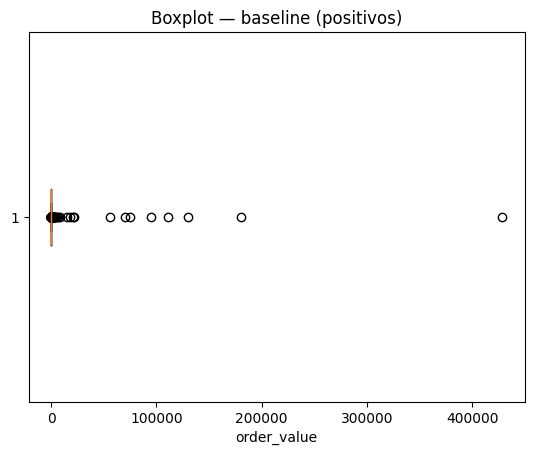

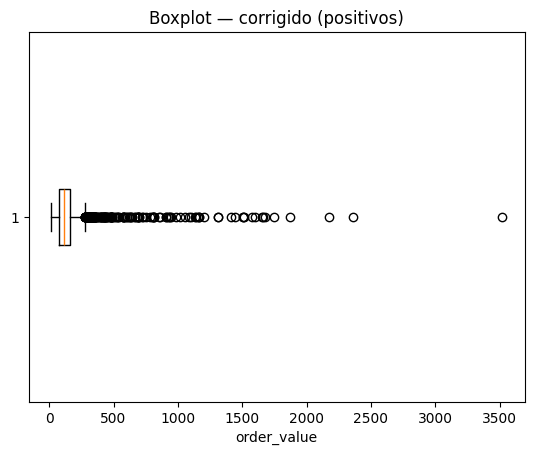

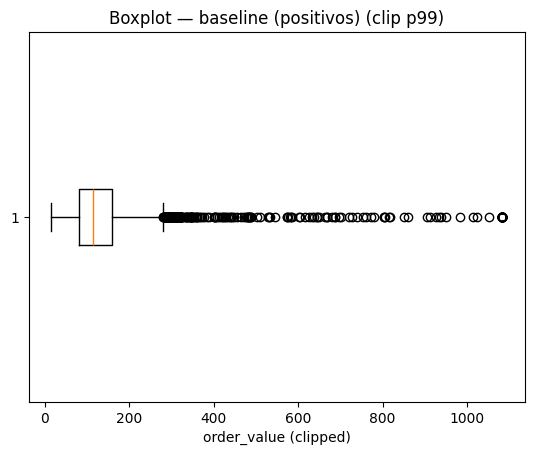

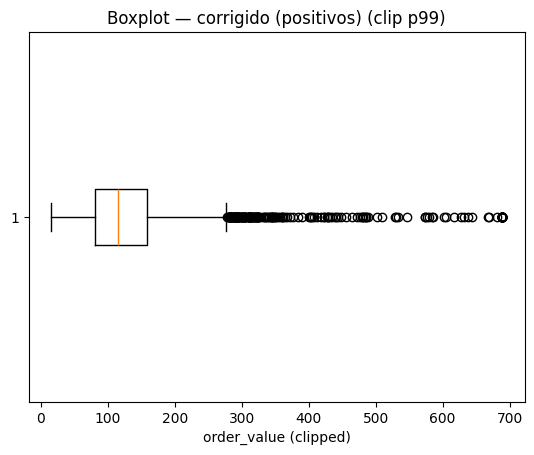

In [ ]:
def plot_box(data, title):
    pos = data.query("order_value > 0")["order_value"]
    plt.figure()
    plt.boxplot(pos, vert=False)
    plt.title(title)
    plt.xlabel("order_value")
    plt.show()

def plot_box_clipped(data, title):
    pos = data.query("order_value > 0")["order_value"]
    p99 = pos.quantile(0.99)
    plt.figure()
    plt.boxplot(pos.clip(upper=p99), vert=False)
    plt.title(title + " (clip p99)")
    plt.xlabel("order_value (clipped)")
    plt.show()

plot_box(baseline, "Boxplot — baseline (positivos)")
plot_box(corrected, "Boxplot — corrigido (positivos)")

plot_box_clipped(baseline, "Boxplot — baseline (positivos)")
plot_box_clipped(corrected, "Boxplot — corrigido (positivos)")


## 7) Simulação: a decisão errada (budget por canal)

Cenário: você tem budget para investir em **1 canal** e decide pelo “melhor” canal.

**Decisão ruim comum:** escolher o canal com maior **ticket médio (média)**, sem validar outliers/anomalias.

Vamos comparar ranking dos canais em 3 abordagens:
1) baseline (média)
2) corrigido (média)
3) robusto: mediana (corrigido) + separar VIP

> O objetivo é ver como **um ou dois pedidos absurdos** podem fazer um canal “parecer” incrível.


In [ ]:
def channel_ranking(data, metric="mean", only_nonvip=False):
    d = data.copy()
    d = d.query("order_value > 0")
    if only_nonvip:
        d = d.query("segment != 'VIP'")
    if metric == "mean":
        out = d.groupby("channel")["order_value"].mean().sort_values(ascending=False)
    elif metric == "median":
        out = d.groupby("channel")["order_value"].median().sort_values(ascending=False)
    else:
        raise ValueError("metric must be 'mean' or 'median'")
    return out

rank_baseline_mean = channel_ranking(baseline, "mean")
rank_corrected_mean = channel_ranking(corrected, "mean")
rank_corrected_median = channel_ranking(corrected, "median")
rank_nonvip_median = channel_ranking(corrected, "median", only_nonvip=True)

pd.DataFrame({
    "baseline_mean": rank_baseline_mean,
    "corrected_mean": rank_corrected_mean,
    "corrected_median": rank_corrected_median,
    "nonVIP_median": rank_nonvip_median
}).sort_values("baseline_mean", ascending=False)


,baseline_mean,corrected_mean,corrected_median,nonVIP_median
channel,,,,
Organic,685.310772,136.404800,115.057898,114.033922
Email,365.520910,147.032734,120.775799,118.871435
Paid Search,332.644017,138.841031,110.719300,109.219601
Social Ads,253.374922,136.734009,115.160987,113.824514
Affiliate,141.874745,139.454315,113.802942,111.252163


### Visual: ranking “muda” ou “não muda”?

Vamos plotar os valores (só para enxergar fácil).


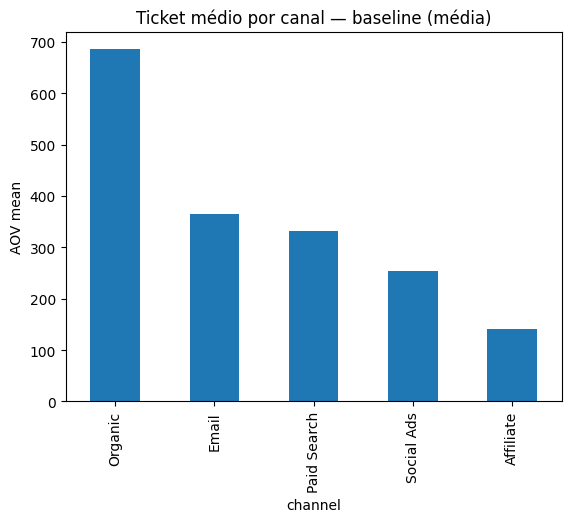

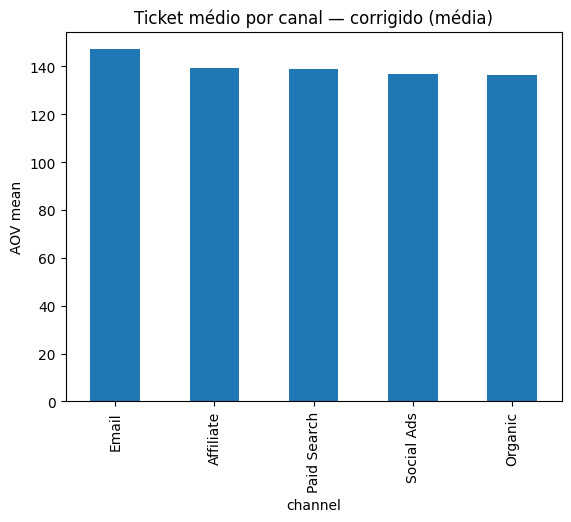

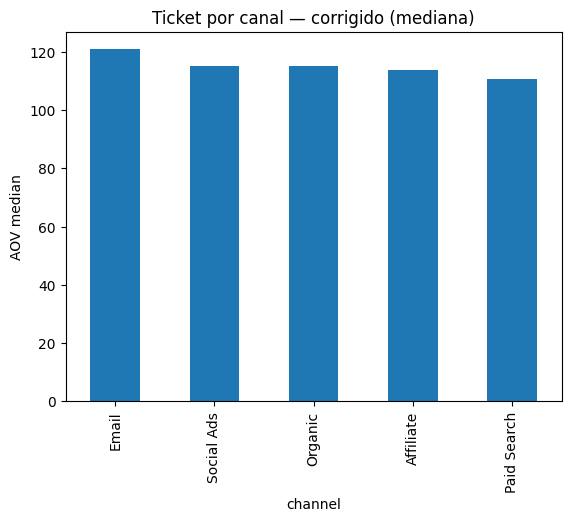

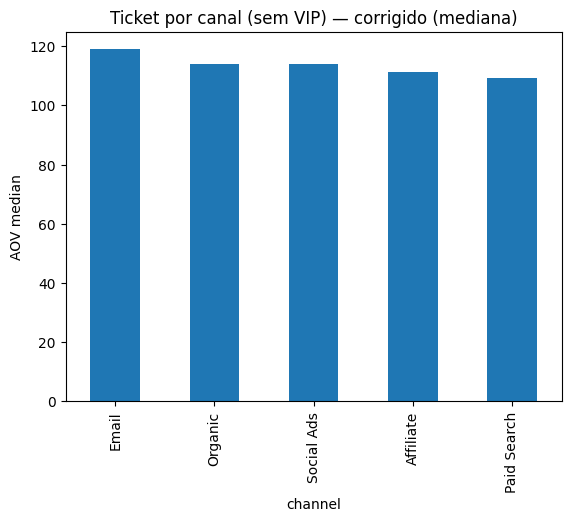

In [ ]:
plt.figure()
rank_baseline_mean.plot(kind="bar")
plt.title("Ticket médio por canal — baseline (média)")
plt.ylabel("AOV mean")
plt.show()

plt.figure()
rank_corrected_mean.plot(kind="bar")
plt.title("Ticket médio por canal — corrigido (média)")
plt.ylabel("AOV mean")
plt.show()

plt.figure()
rank_corrected_median.plot(kind="bar")
plt.title("Ticket por canal — corrigido (mediana)")
plt.ylabel("AOV median")
plt.show()

plt.figure()
rank_nonvip_median.plot(kind="bar")
plt.title("Ticket por canal (sem VIP) — corrigido (mediana)")
plt.ylabel("AOV median")
plt.show()


## 8) Discussão crítica: “dados mentindo” e autoengano

Responda (em 3–5 linhas cada):

1) Qual foi a **decisão errada** que alguém poderia tomar olhando apenas a **média baseline**?  
2) Como você justificaria “remover” vs “segmentar” nesse dataset?  
3) Se você estivesse criando um modelo de ML para prever `order_value`, qual estratégia você escolheria:
   - remover erros + manter VIP
   - remover erros + separar VIP
   - capar em percentil (winsorization)
   - usar loss robusta / transformação log  
   E por quê?


## 9) Exercício final (10–15 min)

Implemente uma quarta estratégia e compare no mesmo `summary`:

### Opção A) Winsorization (cap no p99)
- Crie `winsor = corrected.copy()`
- Para positivos: `order_value = min(order_value, p99)`
- Compare KPIs + ranking por canal

### Opção B) Trimmed mean (média aparada)
- Calcule média removendo top 1% (ou 2%)
- Compare com a média padrão

**Pergunta:** qual abordagem você usaria para reportar “ticket médio” no dashboard executivo?


In [ ]:
# 🚧 Seu espaço de solução:

# winsor = corrected.copy()
# pos_mask = winsor["order_value"] > 0
# p99 = winsor.loc[pos_mask, "order_value"].quantile(0.99)
# winsor.loc[pos_mask, "order_value"] = winsor.loc[pos_mask, "order_value"].clip(upper=p99)

# # Compare KPIs
# summary_winsor = pd.DataFrame([
#     kpi_summary(corrected, "corrigido"),
#     kpi_summary(winsor, "winsor (cap p99)"),
# ])
# summary_winsor

# # Compare ranking
# pd.DataFrame({
#     "corrected_mean": channel_ranking(corrected, "mean"),
#     "winsor_mean": channel_ranking(winsor, "mean"),
#     "corrected_median": channel_ranking(corrected, "median"),
#     "winsor_median": channel_ranking(winsor, "median"),
# })


---

# Fechamento (o “pulo do gato”)

- **Outlier não é vilão automático**: pode ser erro *ou* um comportamento real importante (VIP).
- **Média é frágil**: com cauda longa, “um ponto” muda a história inteira.
- **A pergunta certa não é “tirar ou não”** — é:  
  **“qual decisão este KPI está sustentando e qual risco eu corro se estiver distorcido?”**

Se quiser, eu adapto este notebook para um dataset real (ex.: iFood / Kiva / Bank Marketing) e deixo com perguntas guiadas para os alunos.
